In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

RANDOM_STATE = 42
DEBUG = True
DEMONSTRATION = True

np.random.seed(RANDOM_STATE)

In [97]:
X_train = pd.read_csv('X_train.csv', header=None)
X_train.columns = [f'f_{i}' for i in range(X_train.shape[1])]

y_train = pd.read_csv('y_train.csv', header=None).values.ravel()

X_test = pd.read_csv('X_test.csv', header=None)
X_test.columns = [f'f_{i}' for i in range(X_test.shape[1])]

In [98]:
X_train.drop(columns=[f'f_{i}' for i in range(8)], inplace=True)
X_test.drop(columns=[f'f_{i}' for i in range(8)], inplace=True)

X_train = pd.get_dummies(X_train, columns=['f_13'], prefix='f_13')
X_test = pd.get_dummies(X_test, columns=['f_13'], prefix='f_13')

In [99]:
mask_0 = X_train['f_12'] == 0
mask_1 = X_train['f_12'] == 1

X_train.drop(columns='f_12', inplace=True)

In [100]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'iterations': randint(300, 1500),
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(4, 12),
    'l2_leaf_reg': uniform(1, 15),
    'bagging_temperature': uniform(0, 1),
    'border_count': randint(32, 255),
    'random_strength': uniform(1, 10),
    'leaf_estimation_iterations': randint(1, 10)
}

In [101]:
from catboost import CatBoostRegressor

def run_random_search(X, y, param_dist, random_state, n_iter=100):
    search = RandomizedSearchCV(
        CatBoostRegressor(verbose=0, random_state=random_state, early_stopping_rounds=20),
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=random_state
    )
    search.fit(X, y)
    
    return search.best_estimator_

In [102]:
if DEMONSTRATION:
    model_0 = joblib.load('model_0.pkl')
    model_1 = joblib.load('model_1.pkl')
else:
    model_0 = run_random_search(X_train[mask_0], y_train[mask_0], param_dist, RANDOM_STATE)
    model_1 = run_random_search(X_train[mask_1], y_train[mask_1], param_dist, RANDOM_STATE)
    
    model_0.fit(X_train[mask_0], y_train[mask_0])
    model_1.fit(X_train[mask_1], y_train[mask_1])
    
    joblib.dump(model_0, f"model_0.pkl")
    joblib.dump(model_1, f"model_1.pkl")

In [103]:
from sklearn.model_selection import cross_val_score

if DEBUG:
    scores_0 = -cross_val_score(model_0, X_train[mask_0], y_train[mask_0], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    scores_1 = -cross_val_score(model_1, X_train[mask_1], y_train[mask_1], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    print(f"MSE по фолдам: {scores_0}")
    print(f"Отклонение: {np.std(scores_0)}")
    print(f"Средний MSE: {np.mean(scores_0)}")

    print()

    print(f"MSE по фолдам: {scores_1}")
    print(f"Отклонение: {np.std(scores_1)}")
    print(f"Средний MSE: {np.mean(scores_1)}")

    print()

    len_0 = len(X_train[mask_0])
    len_1 = len(X_train[mask_1])

    print(f"Взвешенный MSE: {(np.mean(scores_0) * len_0 + np.mean(scores_1) * len_1) / (len_0 + len_1)}")

MSE по фолдам: [0.02704528 0.02255584 0.02293553 0.02593817 0.02404676]
Отклонение: 0.0017308623008721854
Средний MSE: 0.024504317149676484

MSE по фолдам: [0.02325347 0.02279134 0.02337219 0.02482727 0.02302923]
Отклонение: 0.0007144677758538352
Средний MSE: 0.02345469800651987

Взвешенный MSE: 0.02398003238766976


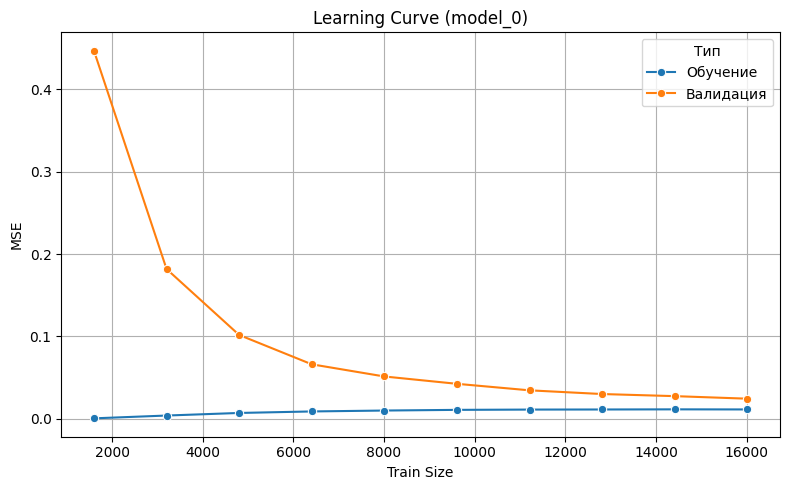

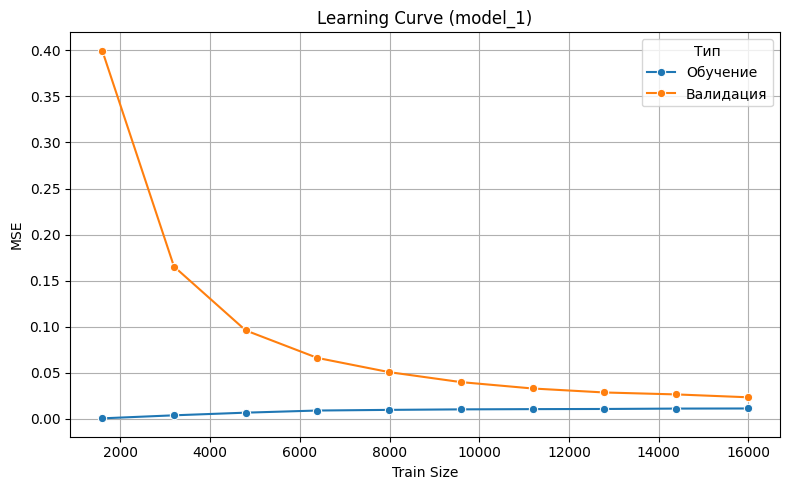

In [104]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    df = pd.DataFrame({
        'Train Size': np.concatenate([train_sizes, train_sizes]),
        'MSE': -np.concatenate([train_scores.mean(axis=1), val_scores.mean(axis=1)]),
        'Тип': ['Обучение'] * len(train_sizes) + ['Валидация'] * len(train_sizes)
    })

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x='Train Size', y='MSE', hue='Тип', marker='o')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if DEBUG:
    plot_learning_curve(model_0, X_train[mask_0], y_train[mask_0], "Learning Curve (model_0)")
    plot_learning_curve(model_1, X_train[mask_1], y_train[mask_1], "Learning Curve (model_1)")

In [105]:
def noise_test(model, X, y, noise_level=0.01):
    y_noisy = y + np.random.normal(0, noise_level * np.std(y), size=len(y))
    score = -cross_val_score(model, X, y_noisy, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    print(f"Noise level: {noise_level}, MSE with noise: {np.mean(score):.4f} ± {np.std(score):.4f}")

if DEBUG:
    print("Noise Test — model_0")
    noise_test(model_0, X_train[mask_0], y_train[mask_0])
    print("Noise Test — model_1")
    noise_test(model_1, X_train[mask_1], y_train[mask_1])

Noise Test — model_0
Noise level: 0.01, MSE with noise: 0.0350 ± 0.0019
Noise Test — model_1
Noise level: 0.01, MSE with noise: 0.0338 ± 0.0013


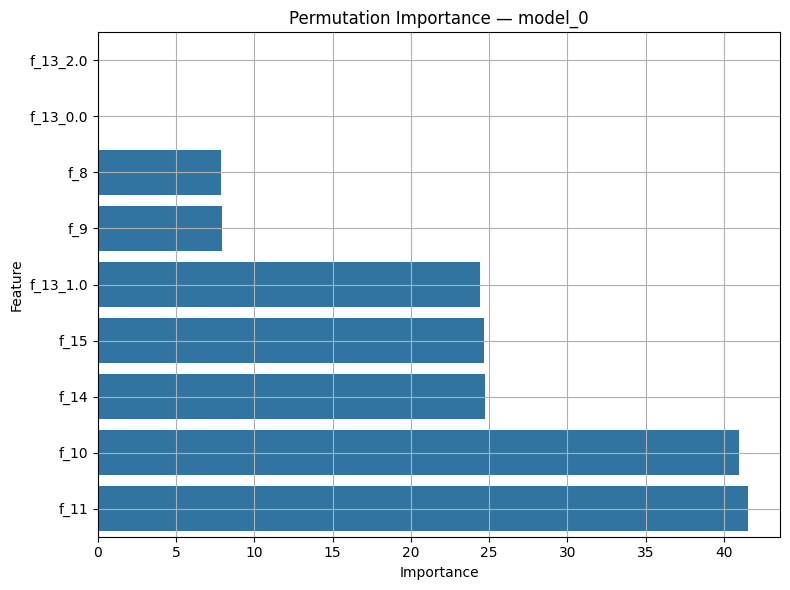

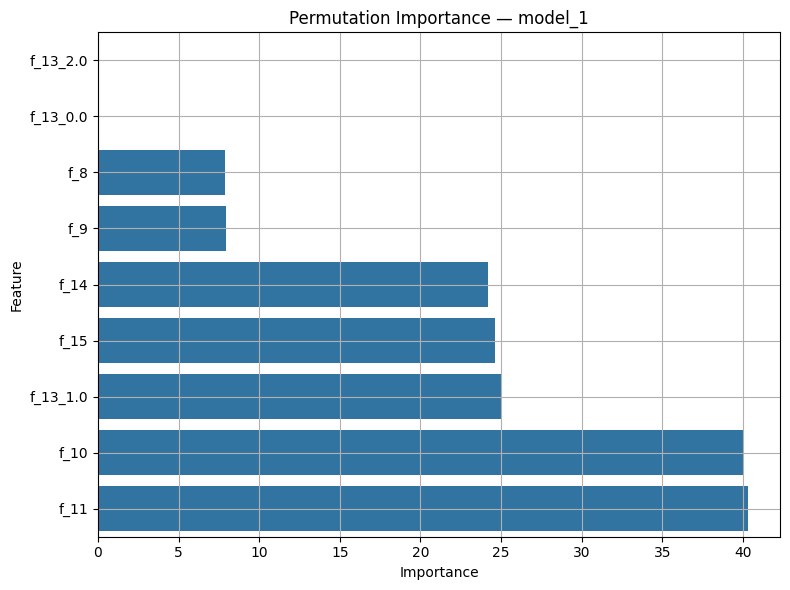

In [106]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X, y, title):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=RANDOM_STATE, scoring='neg_mean_squared_error', n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()
    df = pd.DataFrame({
        'Feature': np.array(X.columns)[sorted_idx],
        'Importance': result.importances_mean[sorted_idx]
    })

    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x='Importance', y='Feature', orient='h')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if DEBUG:
    plot_permutation_importance(model_0, X_train[mask_0], y_train[mask_0], "Permutation Importance — model_0")
    plot_permutation_importance(model_1, X_train[mask_1], y_train[mask_1], "Permutation Importance — model_1")

In [111]:
def train_val_gap(model, X, y, title):
    model.fit(X, y)
    train_preds = model.predict(X)
    train_mse = np.mean((train_preds - y) ** 2)

    val_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    val_mse = np.mean(val_scores)

    print(f"{title}\nTrain MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}, Gap: {abs(val_mse - train_mse):.4f}\n")

if DEBUG:
    train_val_gap(model_0, X_train[mask_0], y_train[mask_0], "Bias-Variance Gap — model_0")
    train_val_gap(model_1, X_train[mask_1], y_train[mask_1], "Bias-Variance Gap — model_1")

Bias-Variance Gap — model_0
Train MSE: 0.0116, Validation MSE: 0.0245, Gap: 0.0129

Bias-Variance Gap — model_1
Train MSE: 0.0106, Validation MSE: 0.0235, Gap: 0.0128



In [ ]:
test_mask_0 = X_test['f_12'] == 0
test_mask_1 = X_test['f_12'] == 1

X_test.drop(columns='f_12', inplace=True)

In [113]:
y_pred_0 = model_0.predict(X_test[test_mask_0])
y_pred_1 = model_1.predict(X_test[test_mask_1])

y_pred = np.empty_like(np.zeros(len(X_test)), dtype=float)
y_pred[test_mask_0] = y_pred_0
y_pred[test_mask_1] = y_pred_1

In [114]:
submission = pd.DataFrame(y_pred, columns=["y"])
submission["ID"] = list(range(len(y_pred)))
submission.to_csv("submission.csv", sep=",", index=False)